In [1]:
from fastplotlib import Plot
from ipywidgets import VBox, HBox
import numpy as np

### Simple image

RFBOutputContext()


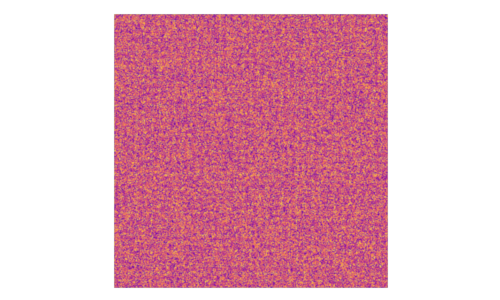

JupyterWgpuCanvas()

In [2]:
# create a `Plot` instance
plot = Plot()

# make some random 2D image data
data = np.random.rand(512, 512)

# plot the image data
plot.image(data=data)

# show the plot
plot.show()

### Update image (video)

RFBOutputContext()


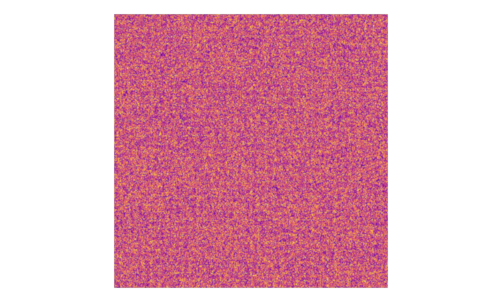

JupyterWgpuCanvas()

In [3]:
# create another `Plot` instance
plot_v = Plot()

# make some random data again
data = np.random.rand(512, 512)

# plot the data, this returns an `ImageGraphic`
image_graphic = plot_v.image(data=data)

# a function to update the image_graphic
def update_data():
    new_data = np.random.rand(512, 512)
    image_graphic.update_data(new_data)

#add this as an animation function
plot_v.add_animations(update_data)

# show the plot
plot_v.show()

### We can share controllers across plots

RFBOutputContext()


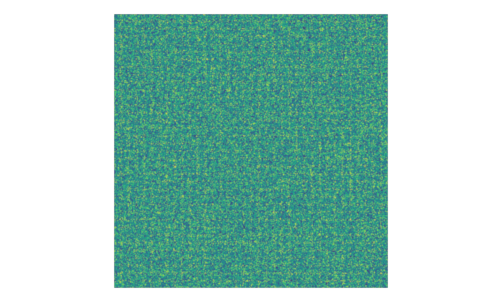

JupyterWgpuCanvas()

In [4]:
plot_sync = Plot(controller=plot_v.controller)

data = np.random.rand(512, 512)
image_2 = plot_sync.image(data=data, cmap="viridis")

def update_data_2():
    new_data = np.random.rand(512, 512)
    image_2.update_data(new_data)

plot_sync.add_animations(update_data_2)

plot_sync.show()

### You can also use `ipywidgets.VBox` and `HBox` to stack plots. See the `gridplot` notebooks for a proper gridplot interface for more automated subplotting

In [5]:
VBox([plot_v.show(), plot_sync.show()])

# Please note that `HBox` can be buggy and unstable, avoid using it
This is an upstream issue in `jupyter-rfb`

In [6]:
HBox([plot_v.show(), plot_sync.show()])

### 2D line plot

RFBOutputContext()


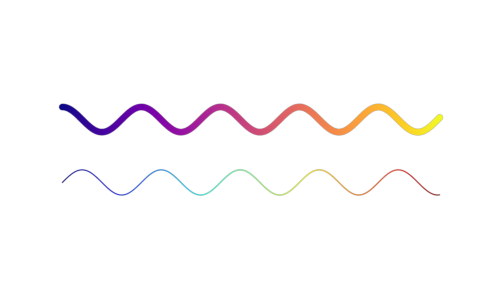

JupyterWgpuCanvas()

In [7]:
plot_l = Plot()

# create data for a sine wave
xs = np.linspace(0, 30, 500)
ys = np.sin(xs)

data1 = np.dstack([xs, ys])[0]

# and cosine wave
ys = np.cos(xs) + 5
data2 = np.dstack([xs, ys])[0]

# we can plot multiple things in the same plot
# this is true for any graphic
plot_l.line(data=data1, size=1.5, cmap="jet")
plot_l.line(data=data2, size=7, cmap="plasma")

plot_l.show()

### 3D line plot

RFBOutputContext()

/home/kushal/Insync/kushalkolar@gmail.com/drive/repos/fastplotlib/fastplotlib/layouts/_subplot.py:148: UserWarning: `center_scene()` not yet implemented for `PerspectiveCamera`
  warn("`center_scene()` not yet implemented for `PerspectiveCamera`")



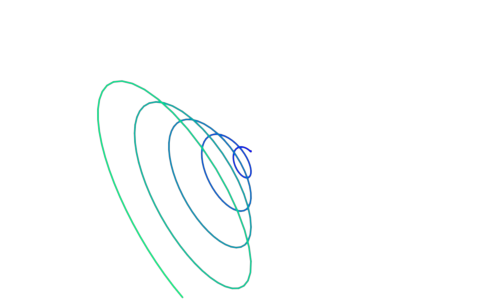

JupyterWgpuCanvas()

In [8]:
# just set the camera as "3d", the rest is basically the same :D 
plot_l3d = Plot(camera='3d')

# create a spiral
phi = np.linspace(0, 30, 200)

xs = phi * np.cos(phi)
ys = phi * np.sin(phi)
zs = phi

# use 3D data
# note: you usually mix 3D and 2D graphics on the same plot
spiral = np.dstack([xs, ys, zs])[0]

plot_l3d.line(data=spiral, size=2, cmap='winter')

plot_l3d.show()

### You can combine VBox and HBox to create more complex layouts

This just plots everything above in a single nb output

In [9]:
row1 = HBox([plot.show(), plot_v.show(), plot_sync.show()])
row2 = HBox([plot_l.show(), plot_l3d.show()])

VBox([row1, row2])